<a href="https://colab.research.google.com/github/SoYeoni621/mulcam/blob/master/LDA_Topicmodeling_init.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install sentence_transformers

     |████████████████████████████████| 79 kB 3.7 MB/s 
     |████████████████████████████████| 4.0 MB 11.0 MB/s 
     |████████████████████████████████| 1.2 MB 41.4 MB/s 
     |████████████████████████████████| 77 kB 6.5 MB/s 
     |████████████████████████████████| 6.6 MB 33.5 MB/s 
     |████████████████████████████████| 895 kB 41.2 MB/s 
     |████████████████████████████████| 596 kB 46.5 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=7fb1d24264befa3c984dd81a840c5643ffb975ce0914068928616e5f7caba4b8
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
from torch.utils.data import DataLoader
from sentence_transformers import SentenceTransformer,  SentencesDataset, LoggingHandler, losses, util, InputExample, models
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
import logging
import math
import numpy as np

In [3]:
logging.basicConfig(format='%(asctime)s - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S',
                    level=logging.INFO,
                    handlers=[LoggingHandler()])

In [4]:
train_batch_size = 16

model_name='/content/drive/MyDrive/프로젝트/kpfbert'
word_embedding_model = models.Transformer(model_name)
# Apply mean pooling to get one fixed sized sentence vector
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(),
                               pooling_mode_mean_tokens=True,
                               pooling_mode_cls_token=False,
                               pooling_mode_max_tokens=False)

Some weights of the model checkpoint at /content/drive/MyDrive/프로젝트/kpfbert were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at /content/drive/MyDrive/프로젝트/kpfbert and are newly initialized: ['bert.pooler.de

In [5]:
model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

2022-04-20 07:50:51 - Use pytorch device: cuda


In [6]:
logging.info("Read AllNLI train dataset")

2022-04-20 07:50:54 - Read AllNLI train dataset


In [7]:
label2int = {"contradiction": 0, "entailment": 1, "neutral": 2}
train_samples = []

In [ ]:
with open('/content/drive/MyDrive/프로젝트/snli_1.0_train.ko.tsv', "rt", encoding="utf-8") as fIn:
    lines = fIn.readlines()
    print(lines)
    for line in lines:
        s1, s2, label = line.split('\t')
        label = label2int[label.strip()]
        train_samples.append(InputExample(texts=[s1, s2], label=label))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
train_dataset = SentencesDataset(train_samples, model=model)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=train_batch_size)
train_loss = losses.SoftmaxLoss(model=model, sentence_embedding_dimension=model.get_sentence_embedding_dimension(), num_labels=len(label2int))

2022-04-19 04:15:18 - Softmax loss: #Vectors concatenated: 3


In [ ]:
#Read STSbenchmark dataset and use it as development set
logging.info("Read STSbenchmark dev dataset")
dev_samples = []

2022-04-19 04:15:22 - Read STSbenchmark dev dataset


In [ ]:
with open('/content/drive/MyDrive/프로젝트/tune_dev.tsv', 'rt', encoding='utf-8') as fIn:
    lines = fIn.readlines()
    for line in lines:
        s1, s2, score = line.split('\t')
        score = score.strip()
        score = float(score) / 5.0
        dev_samples.append(InputExample(texts= [s1,s2], label=score))

In [ ]:
dev_evaluator = EmbeddingSimilarityEvaluator.from_input_examples(dev_samples, batch_size=train_batch_size, name='sts-dev')

In [ ]:
num_epochs = 1

warmup_steps = math.ceil(len(train_dataset) * num_epochs / train_batch_size * 0.1) #10% of train data for warm-up
logging.info("Warmup-steps: {}".format(warmup_steps))

2022-04-19 04:15:28 - Warmup-steps: 3439


In [ ]:
import torch

print("Torch version:{}".format(torch.__version__))
print("cuda version: {}".format(torch.version.cuda))
print("cudnn version:{}".format(torch.backends.cudnn.version()))

Torch version:1.10.0+cu111
cuda version: 11.1
cudnn version:8005


In [ ]:
# Train the model
model.fit(train_objectives=[(train_dataloader, train_loss)],
          evaluator=dev_evaluator,
          epochs=num_epochs,
          evaluation_steps=1000,
          warmup_steps=warmup_steps,
#           output_path=model_save_path
          )

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/34385 [00:00<?, ?it/s]

2022-04-19 04:19:07 - EmbeddingSimilarityEvaluator: Evaluating the model on sts-dev dataset in epoch 0 after 1000 steps:
2022-04-19 04:19:11 - Cosine-Similarity :	Pearson: 0.7025	Spearman: 0.7030
2022-04-19 04:19:11 - Manhattan-Distance:	Pearson: 0.6957	Spearman: 0.7006
2022-04-19 04:19:11 - Euclidean-Distance:	Pearson: 0.6953	Spearman: 0.7001
2022-04-19 04:19:11 - Dot-Product-Similarity:	Pearson: 0.4150	Spearman: 0.4108
2022-04-19 04:22:38 - EmbeddingSimilarityEvaluator: Evaluating the model on sts-dev dataset in epoch 0 after 2000 steps:
2022-04-19 04:22:43 - Cosine-Similarity :	Pearson: 0.6971	Spearman: 0.7133
2022-04-19 04:22:43 - Manhattan-Distance:	Pearson: 0.6987	Spearman: 0.7069
2022-04-19 04:22:43 - Euclidean-Distance:	Pearson: 0.6960	Spearman: 0.7054
2022-04-19 04:22:43 - Dot-Product-Similarity:	Pearson: 0.5600	Spearman: 0.5690
2022-04-19 04:26:14 - EmbeddingSimilarityEvaluator: Evaluating the model on sts-dev dataset in epoch 0 after 3000 steps:
2022-04-19 04:26:18 - Cosine-

KeyboardInterrupt: ignored

In [8]:
train_batch_size = 16
num_epochs = 4
model_save_path = '/content/drive/MyDrive/프로젝트/output/kpfSBERT_nli'

In [9]:
logging.info("Read STSbenchmark train dataset")

2022-04-20 07:51:11 - Read STSbenchmark train dataset


In [10]:
train_samples = []
dev_samples = []
test_samples = []
with open('/content/drive/MyDrive/프로젝트/tune_dev.tsv', 'rt', encoding='utf-8') as fIn:
    lines = fIn.readlines()
    for line in lines:
        s1, s2, score = line.split('\t')
        score = score.strip()
        score = float(score) / 5.0
        dev_samples.append(InputExample(texts= [s1,s2], label=score))

with open('/content/drive/MyDrive/프로젝트/tune_test.tsv', 'rt', encoding='utf-8') as fIn:
    lines = fIn.readlines()
    for line in lines:
        s1, s2, score = line.split('\t')
        score = score.strip()
        score = float(score) / 5.0
        test_samples.append(InputExample(texts= [s1,s2], label=score))

with open('/content/drive/MyDrive/프로젝트/tune_train.tsv', 'rt', encoding='utf-8') as fIn:
    lines = fIn.readlines()
    for line in lines:
        s1, s2, score = line.split('\t')
        score = score.strip()
        score = float(score) / 5.0
        train_samples.append(InputExample(texts= [s1,s2], label=score))

train_dataset = SentencesDataset(train_samples, model)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=train_batch_size)
train_loss = losses.CosineSimilarityLoss(model=model)

In [11]:
# Development set: Measure correlation between cosine score and gold labels
logging.info("Read STSbenchmark dev dataset")
evaluator = EmbeddingSimilarityEvaluator.from_input_examples(dev_samples, name='sts-dev')

warmup_steps = math.ceil(len(train_dataset) * num_epochs / train_batch_size * 0.1) #10% of train data for warm-up
logging.info("Warmup-steps: {}".format(warmup_steps))

2022-04-20 07:51:17 - Read STSbenchmark dev dataset
2022-04-20 07:51:17 - Warmup-steps: 144


In [12]:
# Train the model
model.fit(train_objectives=[(train_dataloader, train_loss)],
          evaluator=evaluator,
          epochs=num_epochs,
          evaluation_steps=1000,
          warmup_steps=warmup_steps,
          output_path=model_save_path)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Iteration:   0%|          | 0/360 [00:00<?, ?it/s]

2022-04-20 07:54:37 - EmbeddingSimilarityEvaluator: Evaluating the model on sts-dev dataset after epoch 0:
2022-04-20 07:54:49 - Cosine-Similarity :	Pearson: 0.8569	Spearman: 0.8531
2022-04-20 07:54:49 - Manhattan-Distance:	Pearson: 0.8476	Spearman: 0.8510
2022-04-20 07:54:49 - Euclidean-Distance:	Pearson: 0.8482	Spearman: 0.8520
2022-04-20 07:54:49 - Dot-Product-Similarity:	Pearson: 0.8489	Spearman: 0.8435
2022-04-20 07:54:50 - Save model to /content/drive/MyDrive/프로젝트/output/kpfSBERT_nli


Iteration:   0%|          | 0/360 [00:00<?, ?it/s]

2022-04-20 07:58:00 - EmbeddingSimilarityEvaluator: Evaluating the model on sts-dev dataset after epoch 1:
2022-04-20 07:58:12 - Cosine-Similarity :	Pearson: 0.8669	Spearman: 0.8648
2022-04-20 07:58:12 - Manhattan-Distance:	Pearson: 0.8552	Spearman: 0.8590
2022-04-20 07:58:12 - Euclidean-Distance:	Pearson: 0.8553	Spearman: 0.8591
2022-04-20 07:58:12 - Dot-Product-Similarity:	Pearson: 0.8476	Spearman: 0.8436
2022-04-20 07:58:12 - Save model to /content/drive/MyDrive/프로젝트/output/kpfSBERT_nli


Iteration:   0%|          | 0/360 [00:00<?, ?it/s]

2022-04-20 08:01:20 - EmbeddingSimilarityEvaluator: Evaluating the model on sts-dev dataset after epoch 2:
2022-04-20 08:01:32 - Cosine-Similarity :	Pearson: 0.8679	Spearman: 0.8657
2022-04-20 08:01:32 - Manhattan-Distance:	Pearson: 0.8585	Spearman: 0.8632
2022-04-20 08:01:32 - Euclidean-Distance:	Pearson: 0.8585	Spearman: 0.8632
2022-04-20 08:01:32 - Dot-Product-Similarity:	Pearson: 0.8537	Spearman: 0.8497
2022-04-20 08:01:32 - Save model to /content/drive/MyDrive/프로젝트/output/kpfSBERT_nli


Iteration:   0%|          | 0/360 [00:00<?, ?it/s]

2022-04-20 08:04:42 - EmbeddingSimilarityEvaluator: Evaluating the model on sts-dev dataset after epoch 3:
2022-04-20 08:04:54 - Cosine-Similarity :	Pearson: 0.8667	Spearman: 0.8652
2022-04-20 08:04:54 - Manhattan-Distance:	Pearson: 0.8578	Spearman: 0.8630
2022-04-20 08:04:54 - Euclidean-Distance:	Pearson: 0.8578	Spearman: 0.8629
2022-04-20 08:04:54 - Dot-Product-Similarity:	Pearson: 0.8541	Spearman: 0.8509


In [13]:
model = SentenceTransformer(model_save_path)
test_evaluator = EmbeddingSimilarityEvaluator.from_input_examples(test_samples, name='sts-test')
test_evaluator(model, output_path=model_save_path)

2022-04-20 08:05:03 - Load pretrained SentenceTransformer: /content/drive/MyDrive/프로젝트/output/kpfSBERT_nli
2022-04-20 08:05:06 - Use pytorch device: cuda
2022-04-20 08:05:06 - EmbeddingSimilarityEvaluator: Evaluating the model on sts-test dataset:
2022-04-20 08:05:16 - Cosine-Similarity :	Pearson: 0.8314	Spearman: 0.8275
2022-04-20 08:05:16 - Manhattan-Distance:	Pearson: 0.8217	Spearman: 0.8245
2022-04-20 08:05:16 - Euclidean-Distance:	Pearson: 0.8214	Spearman: 0.8243
2022-04-20 08:05:16 - Dot-Product-Similarity:	Pearson: 0.8197	Spearman: 0.8144


0.8275059348788516

In [ ]:
# TEST2 : Clustering with k-means

model_path = model_save_path

model = SentenceTransformer(model_path)

# Corpus with example sentences
corpus = ['한 남자가 음식을 먹는다.',
          '한 남자가 빵 한 조각을 먹는다.',
          '그 여자가 아이를 돌본다.',
          '한 남자가 말을 탄다.',
          '한 여자가 바이올린을 연주한다.',
          '두 남자가 수레를 숲 속으로 밀었다.',
          '한 남자가 담으로 싸인 땅에서 백마를 타고 있다.',
          '원숭이 한 마리가 드럼을 연주한다.',
          '치타 한 마리가 먹이 뒤에서 달리고 있다.',
          '한 남자가 파스타를 먹는다.',
          '고릴라 의상을 입은 누군가가 드럼을 연주하고 있다.',
          '치타가 들판을 가로 질러 먹이를 쫓는다.']

corpus_embeddings = model.encode(corpus)

# Then, we perform k-means clustering using sklearn:
from sklearn.cluster import KMeans

num_clusters = 5
clustering_model = KMeans(n_clusters=num_clusters)
clustering_model.fit(corpus_embeddings)
cluster_assignment = clustering_model.labels_

clustered_sentences = [[] for i in range(num_clusters)]
for sentence_id, cluster_id in enumerate(cluster_assignment):
    clustered_sentences[cluster_id].append(corpus[sentence_id])

for i, cluster in enumerate(clustered_sentences):
    print("Cluster ", i+1)
    print(cluster)
    print("")

Cluster  1
['원숭이 한 마리가 드럼을 연주한다.', '고릴라 의상을 입은 누군가가 드럼을 연주하고 있다.']

Cluster  2
['한 남자가 음식을 먹는다.', '한 남자가 빵 한 조각을 먹는다.', '한 남자가 파스타를 먹는다.']

Cluster  3
['치타 한 마리가 먹이 뒤에서 달리고 있다.', '치타가 들판을 가로 질러 먹이를 쫓는다.']

Cluster  4
['한 남자가 말을 탄다.', '두 남자가 수레를 숲 속으로 밀었다.', '한 남자가 담으로 싸인 땅에서 백마를 타고 있다.']

Cluster  5
['그 여자가 아이를 돌본다.', '한 여자가 바이올린을 연주한다.']



In [14]:
import pandas as pd

df1 = pd.read_excel('/content/drive/MyDrive/프로젝트/naver dataset(21-01~22-03/네이버_210101~210131 테스트 데이터.xlsx')
df2 = pd.read_excel('/content/drive/MyDrive/프로젝트/naver dataset(21-01~22-03/네이버_210201~210228 테스트 데이터.xlsx')
df3 = pd.read_excel('/content/drive/MyDrive/프로젝트/naver dataset(21-01~22-03/네이버_210301~210331 테스트 데이터.xlsx')

In [15]:
df = pd.concat([df1, df2, df3], axis=0)

In [16]:
df.reset_index(inplace=True)

In [17]:
df.drop(columns='index', axis=1, inplace=True)

In [18]:
corpus = []
for i in range(len(df)):
    sent = df['content'][i]
    corpus.append(sent)

In [19]:
type(corpus)

list

In [20]:
model_path = model_save_path

model = SentenceTransformer(model_path)

corpus_embeddings = model.encode(corpus)

# Then, we perform k-means clustering using sklearn:
from sklearn.cluster import KMeans

num_clusters = 11
clustering_model = KMeans(n_clusters=num_clusters)
clustering_model.fit(corpus_embeddings)
cluster_assignment = clustering_model.labels_

clustered_sentences = [[] for i in range(num_clusters)]
for sentence_id, cluster_id in enumerate(cluster_assignment):
    clustered_sentences[cluster_id].append(corpus[sentence_id])

for i, cluster in enumerate(clustered_sentences):
    print("Cluster ", i+1)
    print(cluster)
    print("")

2022-04-20 08:06:25 - Load pretrained SentenceTransformer: /content/drive/MyDrive/프로젝트/output/kpfSBERT_nli
2022-04-20 08:06:27 - Use pytorch device: cuda


Batches:   0%|          | 0/71 [00:00<?, ?it/s]

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [21]:
clustered_sentences[0]

['축구장 16개 규모 서비스센터네이버 입점사 8곳만 계약해환경 변화 빠른데 특정사만 의존CJ "테스트 단계, 고객사 늘릴 것"CJ대한통운이 지난해 풀필먼트 서비스를 시작한 곤지암 메가허브 터미널 전경. /사진=CJ대한통운 CJ대한통운이 지난해 계약을 체결한 e-풀필먼트 서비스 고객사 전부가 네이버 브랜드 스토어 입점사로 알려졌다.네이버가 CJ대한통운의 미래 먹거리인 풀필먼트 서비스 실적의 100%를 이끈 셈이다. 올해부터는 3,000억원 규모의 지분교환을 단행한 양사가 물류 협력을 본격적으로 강화한다고 밝히고 있어 CJ대한통운과 네이버 간 ‘풀필먼트 동맹’은 더욱 강화될 것으로 보인다. 다만 CJ대한통운에게는 축구장 16개 규모의 곤지암 풀필먼트 서비스센터 운명을 네이버에만 의존하고 있다는 우려스러운 평가가 제기되고 있다.31일 업계로부터 확인한 CJ대한통운의 풀필먼트 서비스 계약사는 LG생활건강, 라이온코리아, 애경산업, 네슬레코리아,생활공작소, 바나다, 대상라이브사이언스, 뉴트리원 등 총 8개다. 이들 모두 네이버 브랜드스토어 입점사로 네이버가 CJ대한통운과의 풀필먼트서비스 계약과 관련해서 가교 역할을 했다.네이버와 CJ대한통운의 물류 협력은 지난해 10월 양사가 지분교환을 하기 이전부터 시작됐다. 네이버는 지난해 초부터 CJ대한통운과 어떠한 계약을 맺지 않았음에도 자사 입점사의 물류 서비스 개선을 위해 CJ대한통운 풀필먼트 서비스를 적극 제안하고 나섰다. 이에 네이버가 CJ대한통운의 ‘홍보 담당’ 역할을 하고 있다는 평가가 나오기도 했다. 지난해 CJ대한통운과 네이버가 지분교환 협력을 체결하기 이전에 네이버 입점사 중 CJ대한통운 풀필먼트 서비스 계약을 체결한 기업은 LG생활건강, 라이온코리아, 생활공작소, 애경산업 등이다.올해는 네이버 입점사의 CJ대한통운 풀필먼트 서비스 계약 사례는 더욱 급증할 것으로 예상된다. 이와 관련 한성숙 네이버 대표는 지난 28일 열린 컨퍼런스콜에서 “CJ대한통운 풀필먼트 서비스를 이용중인 브랜드사들은 구매자에게 빠른 배송

In [22]:
!pip install kss

     |████████████████████████████████| 42.4 MB 1.3 MB/s 
     |████████████████████████████████| 175 kB 41.4 MB/s 
  Created wheel for kss: filename=kss-3.4.2-py3-none-any.whl size=42448069 sha256=d5c7097bd426c2f300d1d59ac80e7c0c115f63d70ff55e892111eba01bc4f3f9
  Stored in directory: /root/.cache/pip/wheels/ef/22/aa/6399b60516a067ec97fa6599fb2d472aeb25e3f9ee6dae3224
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=7815a247f2a14fb00451b6da93a1bd67e8064da759986721f827eb68dc7f4a03
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
Successfully built kss emoji


In [23]:
!pip install konlpy

     |████████████████████████████████| 19.4 MB 1.3 MB/s 
     |████████████████████████████████| 448 kB 41.8 MB/s 


In [ ]:
!curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash

--2022-04-19 05:35:43--  https://www.dropbox.com/s/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz [following]
--2022-04-19 05:35:44--  https://www.dropbox.com/s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc7bed34ff91021df8e9e972c75f.dl.dropboxusercontent.com/cd/0/get/Bjo7wVjMTQeaAbvAf_IQUDOWgW5bbYV9ziENyCZSMbt3G1_MMMRd5nEhrsGQOGRrJP7b70OJhyBjeeJpIMLkb_KGQe0-jgn8M_9t8JnKwtlHxhnMW_YNdkmrKV-wb8trdOhPOwcSU4ahniTF9J7Tq0xnPJDOlCwC50VtA5KzJPUPyifQ7Ix29n66xQGz31zbl4Q/file?dl=1# [following]
--2022-04-19 05:35:44--  https://uc7bed34ff91021df8e9e972c75f.dl.dropboxusercontent.com/cd/0/g

In [24]:
from collections import Counter
from konlpy.tag import Okt
import kss

In [25]:
clustered_sentences[0][:10]

['축구장 16개 규모 서비스센터네이버 입점사 8곳만 계약해환경 변화 빠른데 특정사만 의존CJ "테스트 단계, 고객사 늘릴 것"CJ대한통운이 지난해 풀필먼트 서비스를 시작한 곤지암 메가허브 터미널 전경. /사진=CJ대한통운 CJ대한통운이 지난해 계약을 체결한 e-풀필먼트 서비스 고객사 전부가 네이버 브랜드 스토어 입점사로 알려졌다.네이버가 CJ대한통운의 미래 먹거리인 풀필먼트 서비스 실적의 100%를 이끈 셈이다. 올해부터는 3,000억원 규모의 지분교환을 단행한 양사가 물류 협력을 본격적으로 강화한다고 밝히고 있어 CJ대한통운과 네이버 간 ‘풀필먼트 동맹’은 더욱 강화될 것으로 보인다. 다만 CJ대한통운에게는 축구장 16개 규모의 곤지암 풀필먼트 서비스센터 운명을 네이버에만 의존하고 있다는 우려스러운 평가가 제기되고 있다.31일 업계로부터 확인한 CJ대한통운의 풀필먼트 서비스 계약사는 LG생활건강, 라이온코리아, 애경산업, 네슬레코리아,생활공작소, 바나다, 대상라이브사이언스, 뉴트리원 등 총 8개다. 이들 모두 네이버 브랜드스토어 입점사로 네이버가 CJ대한통운과의 풀필먼트서비스 계약과 관련해서 가교 역할을 했다.네이버와 CJ대한통운의 물류 협력은 지난해 10월 양사가 지분교환을 하기 이전부터 시작됐다. 네이버는 지난해 초부터 CJ대한통운과 어떠한 계약을 맺지 않았음에도 자사 입점사의 물류 서비스 개선을 위해 CJ대한통운 풀필먼트 서비스를 적극 제안하고 나섰다. 이에 네이버가 CJ대한통운의 ‘홍보 담당’ 역할을 하고 있다는 평가가 나오기도 했다. 지난해 CJ대한통운과 네이버가 지분교환 협력을 체결하기 이전에 네이버 입점사 중 CJ대한통운 풀필먼트 서비스 계약을 체결한 기업은 LG생활건강, 라이온코리아, 생활공작소, 애경산업 등이다.올해는 네이버 입점사의 CJ대한통운 풀필먼트 서비스 계약 사례는 더욱 급증할 것으로 예상된다. 이와 관련 한성숙 네이버 대표는 지난 28일 열린 컨퍼런스콜에서 “CJ대한통운 풀필먼트 서비스를 이용중인 브랜드사들은 구매자에게 빠른 배송

In [26]:
len(clustered_sentences[0])

185

In [27]:
okt = Okt()
news_list=[]

#형태소 분석

for i in range(len(clustered_sentences[0])):
    sentence_list = kss.split_sentences(clustered_sentences[0][i])
    nouns_list = []   
    for sentence in sentence_list:
        nouns = okt.pos(sentence)
        for noun, pos in nouns:
            if pos == 'Noun':
                nouns_list += [noun]

    news_list.append(nouns_list)

2022-04-20 08:09:45 - Initializing Pynori...


In [ ]:
tmp = kss.split_sentences(clustered_sentences[0][0])
nouns_list = []
for sent in tmp:
    nouns = okt.pos(sent)
    for i, j in nouns:
        if j == "Noun":
            nouns_list += [i]

nouns_list

['머니투데이',
 '정인지',
 '기자',
 '올리브영',
 '이하',
 '올리브영',
 '은',
 '열흘',
 '서울시',
 '마포구',
 '연남동',
 '위치',
 '복합',
 '문화',
 '공간',
 '연남',
 '방앗간',
 '클린',
 '뷰티',
 '팝업',
 '스토어',
 '운영',
 '올리브영',
 '자체',
 '캠페인',
 '매장',
 '외부',
 '공간',
 '전개',
 '것',
 '이번',
 '처음',
 '팝업',
 '스토어',
 '나',
 '지구',
 '동물',
 '힘',
 '다정',
 '하우스']

In [28]:
from gensim.corpora import Dictionary

dct = Dictionary(news_list) #형태소 분석을 통해 만든 명사 리스트를 사전으로 생성

2022-04-20 08:30:58 - 'pattern' package not found; tag filters are not available for English
2022-04-20 08:30:58 - adding document #0 to Dictionary(0 unique tokens: [])
2022-04-20 08:30:58 - built Dictionary(2545 unique tokens: ['가교', '간', '감안', '강', '강화']...) from 185 documents (total 48824 corpus positions)


In [29]:
corpus = [dct.doc2bow(text) for text in news_list] #코퍼스 생성

In [30]:
import gensim

NUM_TOPICS = 5 #토픽의 개수를 지정하여 진행하는 경우

ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dct, iterations=50)

2022-04-20 08:31:05 - using symmetric alpha at 0.2
2022-04-20 08:31:05 - using symmetric eta at 0.2
2022-04-20 08:31:05 - using serial LDA version on this node
2022-04-20 08:31:05 - running online (single-pass) LDA training, 5 topics, 1 passes over the supplied corpus of 185 documents, updating model once every 185 documents, evaluating perplexity every 185 documents, iterating 50x with a convergence threshold of 0.001000
2022-04-20 08:31:05 - too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2022-04-20 08:31:06 - -8.523 per-word bound, 367.8 perplexity estimate based on a held-out corpus of 185 documents with 48824 words
2022-04-20 08:31:06 - PROGRESS: pass 0, at document #185/185
2022-04-20 08:31:06 - topic #0 (0.200): 0.030*"네이버" + 0.030*"신세계" + 0.019*"등" + 0.012*"배송" + 0.012*"그룹" + 0.012*"서비스" + 0.011*"오프라인" + 0.011*"대표" + 0.009*"수" + 0.009*"이마트"
2022-04-20 08:31:06 - topic #1 (0.200): 0.032*"네이버" + 0.021*"신세계" 

In [31]:
from gensim.models import CoherenceModel

#Coherence score : 값이 클수록 정확한 데이터
#Perplexity score : 값이 작을수록 정확한 데이터

In [32]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):

#토픽 개수에 따라 Coherence score, Perplexity score 값을 반복 도출하는 사용자 정의 함수

    coherence_values = []
    perplexity_values = []
    model_list = []

    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus, num_topics = num_topics, id2word=dictionary, iterations=50, passes=50)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        perplexity_values.append(ldamodel.log_perplexity(corpus))

    return model_list, coherence_values, perplexity_values

2022-04-20 08:31:26 - using symmetric alpha at 0.2
2022-04-20 08:31:26 - using symmetric eta at 0.2
2022-04-20 08:31:26 - using serial LDA version on this node
2022-04-20 08:31:26 - running online (single-pass) LDA training, 5 topics, 1 passes over the supplied corpus of 185 documents, updating model once every 185 documents, evaluating perplexity every 185 documents, iterating 50x with a convergence threshold of 0.001000
2022-04-20 08:31:26 - too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2022-04-20 08:31:26 - -8.521 per-word bound, 367.4 perplexity estimate based on a held-out corpus of 185 documents with 48824 words
2022-04-20 08:31:26 - PROGRESS: pass 0, at document #185/185
2022-04-20 08:31:26 - topic #0 (0.200): 0.040*"네이버" + 0.034*"신세계" + 0.018*"등" + 0.012*"대표" + 0.012*"서비스" + 0.012*"교환" + 0.012*"오프라인" + 0.012*"그룹" + 0.011*"수" + 0.011*"이마트"
2022-04-20 08:31:26 - topic #1 (0.200): 0.059*"네이버" + 0.023*"신세계" 

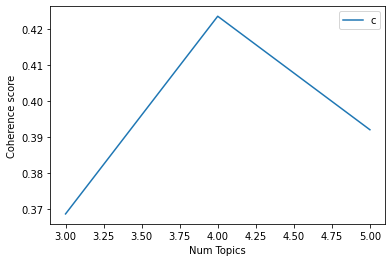

In [33]:
import matplotlib.pyplot as plt

Ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dct, iterations=50)
model_list, coherence_values, perplexity_values = compute_coherence_values(dictionary=dct, corpus=corpus, texts=news_list, start=3, limit=6, step=1)
limit=6; start=3; step=1;

#토픽의 개수를 3~5개로 제한하여 Coherence score, Perplexity score 값을 연속적으로 도출
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

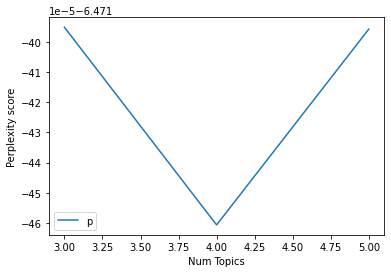

In [34]:
x = range(start, limit, step)

plt.plot(x, perplexity_values)
plt.xlabel("Num Topics")
plt.ylabel("Perplexity score")
plt.legend(("perplexity_values"), loc='best')
plt.show()

In [35]:
!pip install pyLDAvis

     |████████████████████████████████| 1.7 MB 5.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=02e70e8e9e76bbbdce20ab2519ec73b306e425d1c93baeae54e69c3e78c47c9b
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis


In [37]:
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()
ldamodel = model_list[1] #Coherence score 값이 가장 크고, Perplexity score 값이 가장 작은 점
lda_display = pyLDAvis.gensim_models.prepare(ldamodel, corpus, dct, sort_topics=False)
pyLDAvis.display(lda_display)
pyLDAvis.save_html(lda_display, '/content/drive/MyDrive/프로젝트/Topic.html')
topics = ldamodel.print_topics()
for topic in topics:

    print(topic)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


2022-04-20 08:33:38 - topic #0 (0.250): 0.056*"네이버" + 0.054*"신세계" + 0.022*"이마트" + 0.021*"등" + 0.021*"그룹" + 0.016*"교환" + 0.016*"대표" + 0.015*"오프라인" + 0.015*"분" + 0.014*"서비스"
2022-04-20 08:33:38 - topic #1 (0.250): 0.039*"네이버" + 0.022*"신세계" + 0.018*"것" + 0.015*"쿠팡" + 0.012*"시장" + 0.012*"그룹" + 0.011*"수" + 0.011*"온라인" + 0.010*"등" + 0.009*"이마트"
2022-04-20 08:33:38 - topic #2 (0.250): 0.045*"네이버" + 0.025*"배송" + 0.020*"물류" + 0.016*"서비스" + 0.015*"통운" + 0.012*"쇼핑" + 0.011*"등" + 0.011*"브랜드" + 0.009*"판매" + 0.008*"상품"
2022-04-20 08:33:38 - topic #3 (0.250): 0.046*"네이버" + 0.027*"리테일" + 0.025*"오프라인" + 0.024*"편의점" + 0.019*"대표" + 0.016*"서비스" + 0.016*"등" + 0.015*"양사" + 0.015*"고객" + 0.014*"플랫폼"
(0, '0.056*"네이버" + 0.054*"신세계" + 0.022*"이마트" + 0.021*"등" + 0.021*"그룹" + 0.016*"교환" + 0.016*"대표" + 0.015*"오프라인" + 0.015*"분" + 0.014*"서비스"')
(1, '0.039*"네이버" + 0.022*"신세계" + 0.018*"것" + 0.015*"쿠팡" + 0.012*"시장" + 0.012*"그룹" + 0.011*"수" + 0.011*"온라인" + 0.010*"등" + 0.009*"이마트"')
(2, '0.045*"네이버" + 0.025*"배송" + 0.020*"물

# 연관분석

In [38]:
df

,title,paper,date,url,content
0,네이버·카카오로도 기차 예매한다…통합 교통 정보 제공(종합),조선비즈,2021.01.31.,https://news.naver.com/main/read.naver?mode=LS...,네이버와 카카오모빌리티는 오는 1일부터 한국철도공사 기차 예매 서비스를 제공한다고 ...
1,2월부터 ‘네이버’·‘카카오T’ 앱에서 KTX 승차권 바로 예약,아시아경제신문,2021.01.31.,https://news.naver.com/main/read.naver?mode=LS...,"‘코레일톡’ 없어도, 철도회원 가입 안해도 예약 가능…비대면 서비스 강화 한국철도는..."
2,"네이버 지도, 기차예매부터 맛집 검색까지 다 된다",ZDNet Korea,2021.01.31.,https://news.naver.com/main/read.naver?mode=LS...,한국철도공사 기차 운행 정보 제공...지역 정보 유용네이버는 2월1일부터 '네이버 ...
3,"[시그널] 네이버, 국내외서 1조 이상 투자자금 조달한다",서울경제,2021.01.31.,https://news.naver.com/main/read.naver?mode=LS...,회사채 발행 계획 본격화...1분기 내 1조원 넘는 현금 쥘 듯대규모 실탄 마련해 ...
4,"네이버, 벌어들인 돈보다 R&D 투자에 더 쓴다…왜?",inews24.com,2021.01.31.,https://news.naver.com/main/read.naver?mode=LS...,중소상공인 디지털 전환 앞장…지난해 매출 대비 R&D 투자 비율 25% 네이버가 지...
...,...,...,...,...,...
2246,"네이버와 손잡은 LG전자, '웨일북'으로 크롬북 시장 흔들까",inews24.com,2021.03.26.,https://news.naver.com/main/read.naver?mode=LS...,이르면 하반기께 웨일북 출시…크롬북 대비 콘텐츠 등 경쟁력 확보 관건장익환 LG전자...
2247,네이버·엔씨 평균 연봉 1억원 넘었다,헤럴드경제,2021.03.17.,https://news.naver.com/main/read.naver?mode=LS...,작년 각각 1억248만·1억550만원창업자들 연봉도 역대급 기록이해진 19억·김택진...
2248,신세계-네이버 동맹 현실화…오후 이사회 열고 확정,financial news,2021.03.16.,https://news.naver.com/main/read.naver?mode=LS...,네이버와 이마트가 동맹을 현실화한다. 신세계그룹과 네이버는 16일 오후 각각 이사회...
2249,네이버-신세계-CJ '反쿠팡 동맹' 떴다,매경닷컴,2021.03.16.,https://news.naver.com/main/read.naver?mode=LS...,3개사 잇달아 지분 맞교환이베이 입찰에 대기업 다수 참여◆ 쿠팡發 유통빅뱅 ④ ◆온...


In [39]:
!pip install --upgrade mlxtend

     |████████████████████████████████| 1.3 MB 5.3 MB/s 
  Attempting uninstall: mlxtend
    Found existing installation: mlxtend 0.14.0
    Uninstalling mlxtend-0.14.0:
      Successfully uninstalled mlxtend-0.14.0


In [40]:
import mlxtend
import numpy as np
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import association_rules
from mlxtend.frequent_patterns import fpgrowth
import time

In [41]:
import tqdm
import math
from collections import Counter

In [44]:
from konlpy.tag import Okt

okt = Okt()
df['Nouns'] = df['content'].apply(okt.nouns)

KeyboardInterrupt: ignored

In [ ]:
test = []
for doc in data1['Nouns']:
    for word in doc:
        if word.isalnum() == False or word.isdigit() == True or len(word) == 1:
            continue
        test.append(word)

vocab = list(set(test))
vocab.sort()

In [ ]:
def tf(t, d):
    return d.count(t)

N = len(data1)

result = []
for i in tqdm.tqdm(range(N)):
    result.append([])
    d = data1['본문'][i]
    
    for j in range(len(vocab)):
        t = vocab[j]
        result[-1].append(tf(t, d))

tf_ = pd.DataFrame(result, columns=vocab)

100%|██████████| 1606/1606 [00:07<00:00, 218.47it/s]


In [ ]:
from math import log

def idf(t):
    df_=0
    for doc in data1['Nouns']:
        df_ += t in doc
    return log(N/(df_ + 1))

result = []
for j in range(len(vocab)):
    t = vocab[j]
    result.append(idf(t))
    
idf_ = pd.DataFrame(result, index = vocab, columns=["IDF"])

In [ ]:
def tfidf(t, d):
    return tf(t, d) * idf(t)

result = []
for i in tqdm.tqdm(range(N)):
    result.append([])
    d = df['본문'][i]
    for j in range(len(vocab)):
        t = vocab[j]
        
        result[-1].append(tfidf(t, d))

 85%|████████▌ | 1370/1606 [3:52:19<39:51, 10.13s/it]

# Apriori

In [45]:
df.to_excel('/content/drive/MyDrive/프로젝트/naver_news.xlsx')

In [ ]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori

In [ ]:
stop_words = ['등', '은', '기자', '한','가', '는','것','나','수','이','준','날','후','로','으로', '통','달','을','를','앱','매일경제', 
              '한국경제','매경','분','한경','머니투데이','씨']

In [ ]:
for i in range(len(data1)):
    words = []
    for j in range(len(data1['Nouns'][i])):
        if data1['Nouns'][i][j] not in stop_words:
            words.append(data1['Nouns'][i][j])
    data1['Noun'][i] = words

In [ ]:
dataset = []
for i in range(len(data1)):
    dataset.append(data1.Noun[i])

In [ ]:
te = TransactionEncoder()
te_result = te.fit(dataset).transform(dataset)

In [ ]:
te_df = pd.DataFrame(te_result, columns=te.columns_)
te_df

In [ ]:
itemset = apriori(te_df, use_colnames=True)
itemset

In [ ]:
itemset = apriori(te_df, min_support=0.1, use_colnames=True)
itemset

In [ ]:
from mlxtend.frequent_patterns import association_rules
association_rules(itemset, metric="confidence", min_threshold=0.1)